In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import time
import random

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
sns.set_style("ticks", { "xtick.major.size": 4, "ytick.major.size": 4, "font_color":'k', 'axes.edgecolor': 'k', 'xtick.color': 'k', 'ytick.color': 'k'})

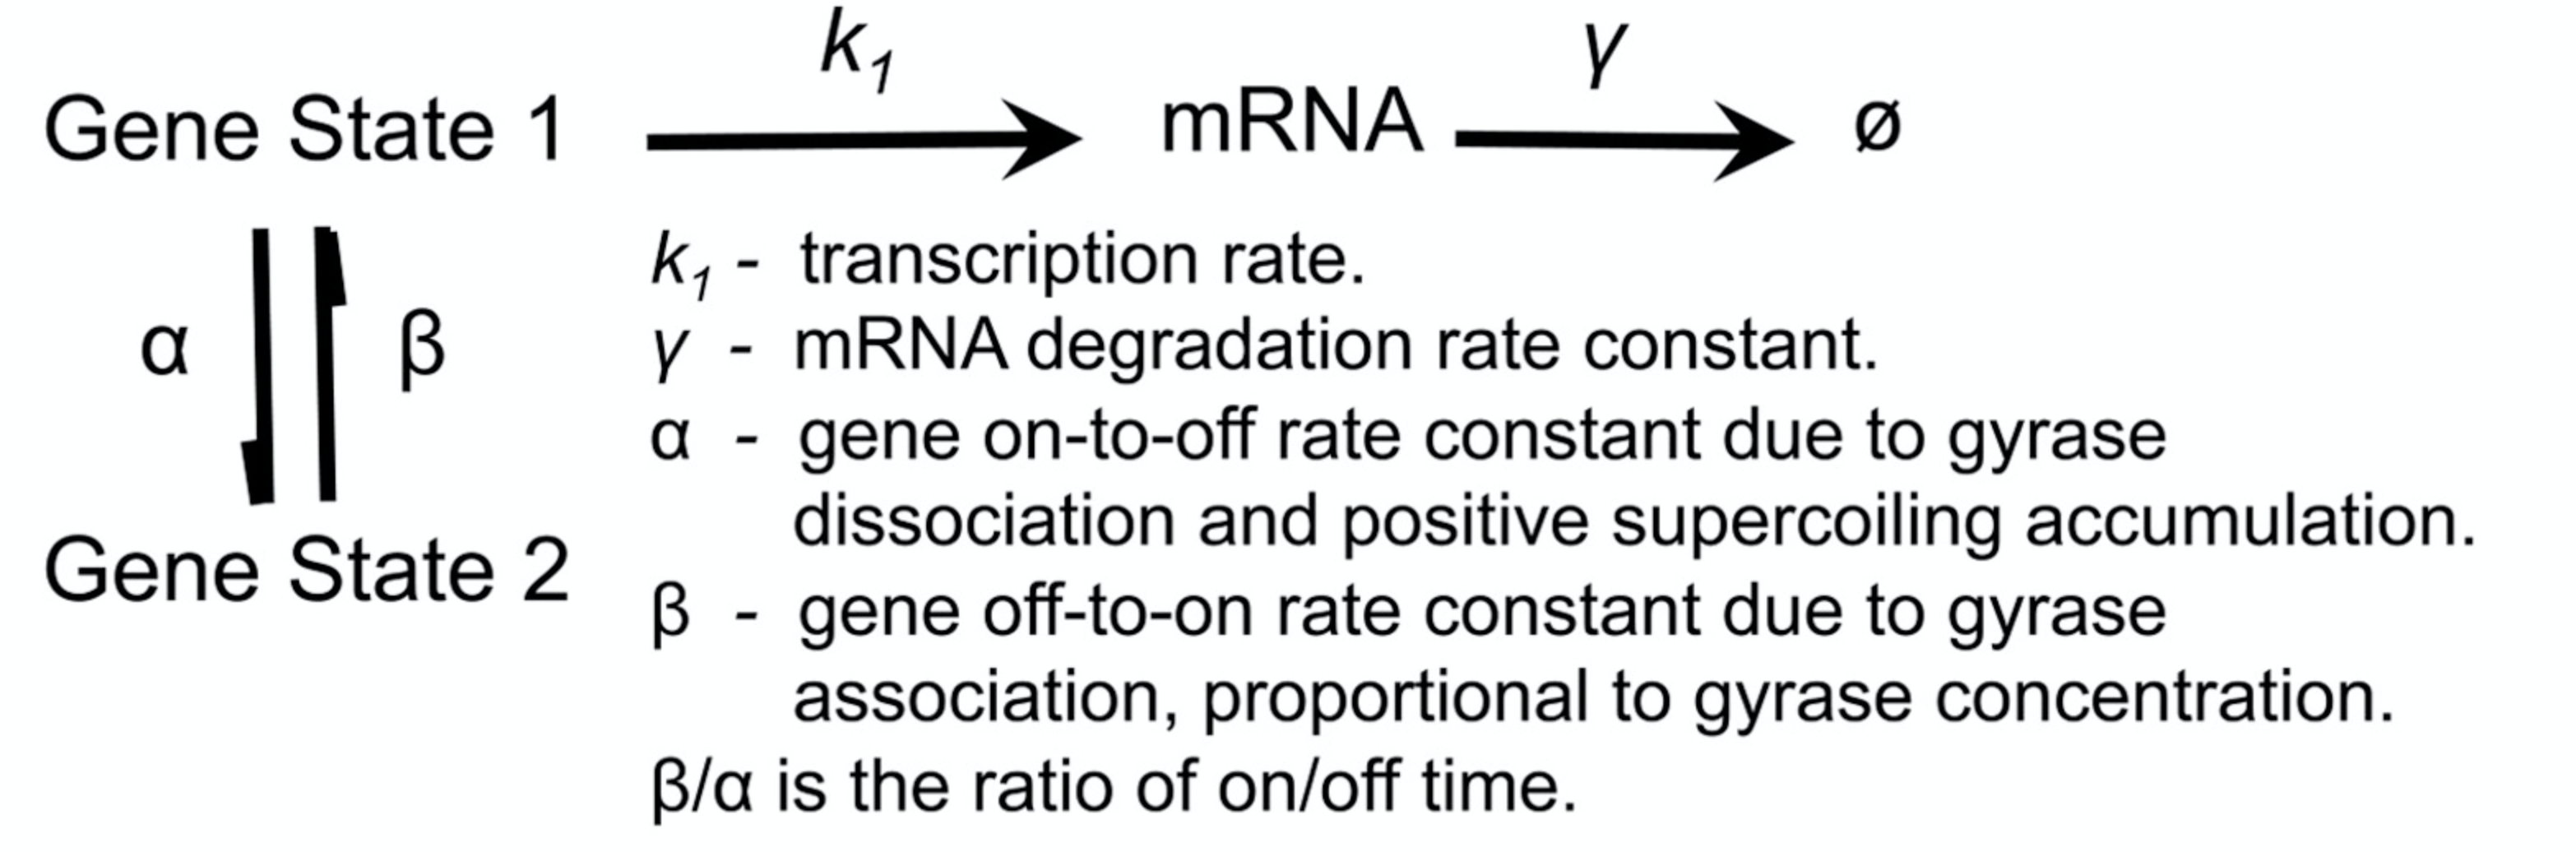

So:

$x$ is produced at rate $\alpha$ and degraded at rate $\beta$ while gene is ON, and degraded at rate $\beta$ while gene is OFF. 

$$k_s(x) = k_s^* \cdot \frac{x}{x^*} $$

$$k_a(x) = k_a^*$$

In [6]:
def hill(x, kd, n):
    return x**n/(x**n + kd**n)

def biased_flip(prob_true=0.5):
    if random.random() < prob_true:
        return 1.0
    else:
        return 0.0

def simulate_cell(p_prd, p_deg, ka, ks_max, sim_runtime, starting_p_on):
    t_states = [0.0]
    g_state = biased_flip(starting_p_on)
    g_states = [g_state]
    max_p = (1.0*p_prd)/p_deg
    p_states = [0 if g_state==0 else max_p]
    
    timepoints = np.linspace(0, sim_runtime, 1000).tolist()
    timevalues = [g_state]
    cur_timepoint_ind = 1
        
    while t_states[-1] < sim_runtime: 
        g_state = g_states[-1]
        p_state = p_states[-1]
        t_state = t_states[-1]

        if g_state == 0: #OFF
            rate_p_deg = p_deg * p_state
            rate_g_on  = ka 
            if p_state > 0:
                dart = np.random.uniform(0.0, rate_p_deg + rate_g_on)
                timestep = np.random.exponential(1.0/(rate_p_deg + rate_g_on))
                if dart < rate_p_deg: # degrade 
                    g_states.append(g_state)
                    p_states.append(p_state - 1)
                elif dart >= rate_p_deg: # turn gene ON 
                    g_states.append(g_state + 1)
                    p_states.append(p_state)
            elif p_state == 0:
                timestep = np.random.exponential(1.0/rate_g_on)
                g_states.append(g_state + 1)
                p_states.append(p_state)
        elif g_state == 1: #ON
            rate_p_deg = p_deg * p_state
            rate_p_prd = p_prd
            rate_g_off = ks_max * hill(p_state, max_p/3.0, 3.0) # ultrasensitive response
            if p_state > 0:
                dart = np.random.uniform(0.0, rate_p_deg + rate_p_prd + rate_g_off)
                timestep = np.random.exponential(1.0/(rate_p_deg + rate_p_prd + rate_g_off))                
                if dart < rate_p_deg: # degrade
                    g_states.append(g_state)
                    p_states.append(p_state - 1)
                elif dart >= rate_p_deg and dart < rate_p_deg + rate_p_prd: # produce
                    g_states.append(g_state)
                    p_states.append(p_state + 1)
                elif dart >= rate_p_deg + rate_p_prd: #turn gene off
                    g_states.append(g_state - 1)
                    p_states.append(p_state)
            elif p_state == 0: 
                dart = np.random.uniform(0.0, rate_p_prd + rate_g_off) 
                timestep = np.random.exponential(1.0/(rate_p_prd + rate_g_off))
                if dart < rate_p_prd: # produce
                    g_states.append(g_state)
                    p_states.append(p_state + 1)
                elif dart >= rate_p_prd: # turn gene off
                    g_states.append(g_state - 1)
                    p_states.append(p_state)
        t_states.append(t_state + timestep)        

        while (cur_timepoint_ind < len(timepoints)) and (timepoints[cur_timepoint_ind] > t_states[-2]) and (timepoints[cur_timepoint_ind] <= t_states[-1]):
            timevalues.append(g_states[-2])
            cur_timepoint_ind = cur_timepoint_ind+1

    return [t_states, g_states, p_states, timepoints, timevalues]

def plot_cell(cell_array, ax, title, steadystate, pprod, pdeg, ks, tlim = 2):
    times = cell_array[0]
    gene_states = cell_array[1]
    mrna_states = cell_array[2]
    
    ax.step(times, mrna_states, color='tab:blue')
    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('Prot. (AU)', color='tab:blue')
    ax.set_ylim(0, 2*(pprod/pdeg))
    ax.set_yticks([0, (pprod/pdeg)])
    ax.hlines(pprod/pdeg, xmin=0, xmax=2, linestyles='dashed', label='', zorder=10)

     
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlim(0, tlim)
    ax.set_xticks([0, tlim/2, tlim])
       
    ax1 = ax.twinx()
    ax1.set_ylabel('Gene', color='tab:red')
    ax1.step(times, gene_states, color='tab:red', where='post')    
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(["Off", "On"])
    
    ax2 = ax.twinx()
    ax2.fill_between(
        times, 
        gene_states, 
        step="post", 
        facecolor='tab:red', 
        alpha=0.1)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_yticks([])
    
    ax.set_title(title)
    
    df = pd.DataFrame.from_dict({
        'time'  : times,
        'gene'  : [g + 0.1 if g == 1 else 0 for g in gene_states],
        'prot'  : mrna_states,
        'pprod' : [pprod for t in times],
        'pdeg'  : [pdeg for t in times],
        'sstate' : [pprod/pdeg for t in times],
        'ks' : [ks for t in times]
    })
    return df

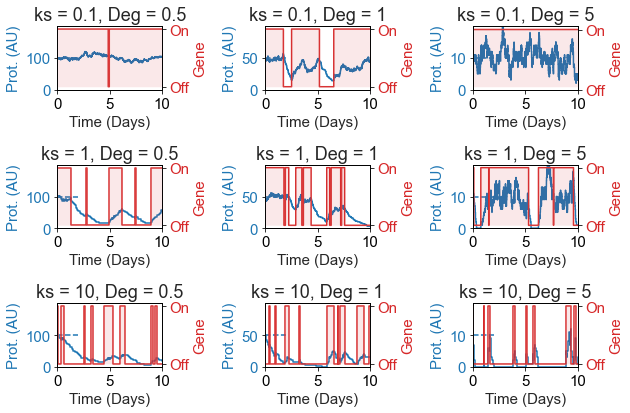

In [32]:
plt.rcParams.update({'font.size': 15})

kss = [0.1, 1, 10]
pdegs = [0.5, 1, 5]

ncols = len(pdegs)
nrows = len(kss)

dfs = []

fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))

pprod = 50

for i in range(len(kss)):
    for j in range(len(pdegs)):
        c = simulate_cell(pprod, pdegs[j], 1.0, kss[i], 10, 1)
        df = plot_cell(c, ax[i][j], 
                       "ks = "+str(kss[i])+", Deg = "+str(pdegs[j]), 
                       pprod/pdegs[j],
                       pprod, pdegs[j], kss[i], 10)
        dfs.append(df)
        
plt.tight_layout()
plt.savefig('./gillespie_single_cell_traces.pdf', bbox_inches='tight')

full_df = pd.concat(dfs, ignore_index=True)
full_df.head()
full_df.to_csv('./gillespie_single_cell_trajectories.csv')

In [45]:
full_df.head()

,time,gene,prot,pprod,pdeg,sstate,ks
0,0.000000,1.1,100.0,5000,50,100.0,0.1
1,0.000042,1.1,101.0,5000,50,100.0,0.1
2,0.000055,1.1,100.0,5000,50,100.0,0.1
3,0.000128,1.1,99.0,5000,50,100.0,0.1
4,0.000168,1.1,98.0,5000,50,100.0,0.1


In [23]:
def get_relevant_idx(t, target, start_idx=0):
    if t[0] >= target:
        return 0
    for i in range(start_idx, len(t)-1):
        if t[i] < target and t[i+1] >= target:
            return i
    return len(t)-1

def scan_for_timepoint_idx(times, timepoints, sim_runtime):
    scan_idxs = [-1 for t in timepoints]
    for i in range(len(timepoints)):
        scan_idxs[i] = get_relevant_idx(times, timepoints[i])
    
    return scan_idxs

def scan_for_on_cells(cells, sim_runtime):
    timepoints = np.linspace(0, sim_runtime, 100)
    gene_exps = [c[1] for c in cells]
    time_vals = [c[0] for c in cells]
    gene_filt = [[gene_exps[row][col] 
                                  for col in scan_for_timepoint_idx(time_vals[row], timepoints, sim_runtime)] 
                                  for row in range(len(gene_exps))]
    ons = np.divide(np.sum(np.asmatrix(gene_filt), axis=0).tolist()[0], len(gene_filt))
    #ons = [np.mean([g[row][col] for row in range(len(gene_filt))]) for col in range(len(gene_filt[0]))]
    return timepoints, ons

def count_on_cells(cells, time):
    count = 0
    idx = 0
    
    for c in cells:
        t = c[0]
        g = c[1]
        
        idx = get_relevant_idx(t, time, idx)
        if g[idx] == 1:
            count = count + 1
    return (count * 1.0)/len(cells)

def simulate_many_cells(p_prd, p_deg, ka, ks_max, sim_runtime, n_cells, starting_p_on):
    cells = [simulate_cell(p_prd, p_deg, ka, ks_max, sim_runtime, starting_p_on) for c in range(n_cells)]
    
    timepoints = [c[3] for c in cells]
    p_ons = [c[4] for c in cells]
    p_ons = np.mean(np.asmatrix(p_ons), axis=0).tolist()[0]
    
    final_protein_states = [c[2][-1] for c in cells]
    
    return [timepoints[0], p_ons, final_protein_states]

def get_many_cells(p_prd, p_deg, ka, ks_max, sim_runtime, n_cells, starting_p_on):
    timepoints, p_ons, protein_states = simulate_many_cells(p_prd, p_deg, 
                                                            ka, ks_max, 
                                                            sim_runtime, n_cells, starting_p_on)
    return [timepoints, p_ons, protein_states]

def plot_many_curves(ax, pprod, pdeg, ka, ks, plot_legend=False, fsize=16):
    pcts = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    # let's build the dataframes
    times = []
    p_ons = []
    starting_ons = []
    kas = []
    kss = []
    pprods = []
    pdegs = []
    
    p_starting_ons = []
    p_kas = []
    p_kss = []
    p_pprods = []
    p_pdegs = []
    p_final_ps = []
    
    for i in range(len(pcts)):
        p = pcts[i]
        c = get_many_cells(pprod, pdeg, ka, ks, 30, 200, p)
                
        ts = c[0]
        ps = c[1]
        ss = [p for t in ts]
        ka_vals = [ka for t in ts]
        ks_vals = [ks for t in ts]
        pprod_vals = [pprod for t in ts]
        pdeg_vals = [pdeg for t in ts]              
        times.extend(ts)
        p_ons.extend(ps)
        starting_ons.extend(ss)
        kas.extend(ka_vals)
        kss.extend(ks_vals)
        pprods.extend(pprod_vals)
        pdegs.extend(pdeg_vals)
        
        final_ps = [x/((1.0*pprod)/pdeg) for x in c[2]]
        pkas =    [ka for f in final_ps]
        pkss =    [ks for f in final_ps]
        ppprods = [pprod for f in final_ps]
        ppdegs =  [pdeg for f in final_ps]
        pa0s =    [p for f in final_ps]
        p_starting_ons.extend(pa0s)
        p_kas.extend(pkas)
        p_kss.extend(pkss)
        p_pprods.extend(ppprods)
        p_pdegs.extend(ppdegs)
        p_final_ps.extend(final_ps)
        
    df = pd.DataFrame.from_dict({
        "Time" : times,
        "Fraction On" : p_ons,
        "A(0)" : starting_ons,
        "ka" : kas,
        "ks" : kss,
        "pprod" : pprods,
        "pdeg" : pdegs
    })
        
    leg = "full" if plot_legend else False
    g = sns.lineplot(x="Time", y="Fraction On", hue="A(0)", data=df, 
                     palette='viridis', legend=leg, linewidth=4, ax=ax)
            
    #g.legend(loc='upper right')
    g.set_xlabel('Time (days)', fontsize=fsize)
    g.set_ylabel('Fraction On', fontsize=fsize)
    g.set_xlim([0.0, 10.0])
    g.set_xticks([0, 1, 2])
    g.set_xticklabels([0, 5, 10], fontsize=fsize)
    g.set_ylim([0.0, 1.0])
    g.set_yticks([0, 0.5, 1.0])
    g.set_yticklabels([0, 0.5, 1.0], fontsize=fsize)
    
    if plot_legend:
        l = g.legend(fontsize=fsize)
    
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.set_title('p_deg: '+str(pdeg)+', p_prod: '+str(pprod), fontsize=fsize)
    
    df2 = pd.DataFrame.from_dict({
        'a0' : p_starting_ons,
        'ka' : p_kas,
        'ks' : p_kss,
        'pprod' : p_pprods,
        'pdeg' : p_pdegs,
        'prot' : p_final_ps
    })
    
    return df, df2


pdeg=1, pprod=50
8 seconds taken
pdeg=1, pprod=100
14 seconds taken
pdeg=5, pprod=50
7 seconds taken
pdeg=5, pprod=100
14 seconds taken


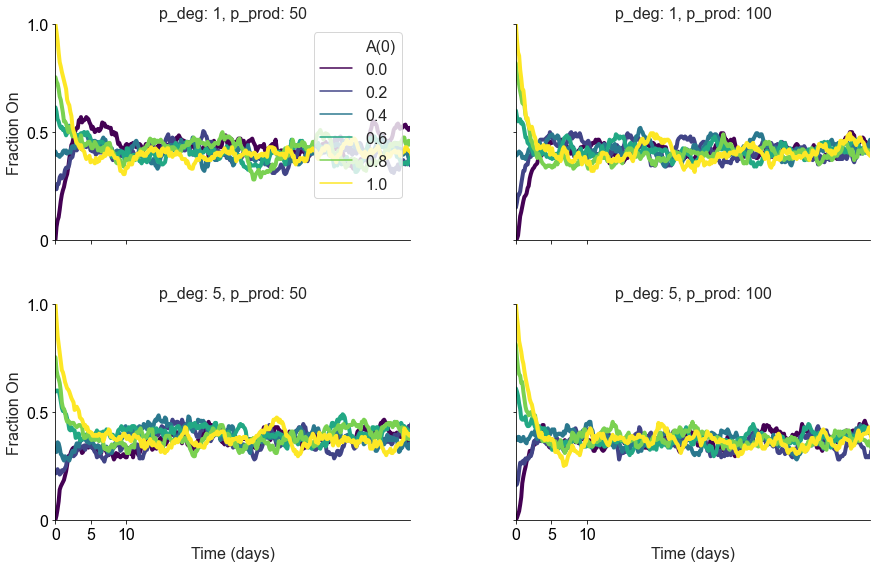

In [25]:
pprods = [0.1, 0.5, 1, 5, 10, 50]
pdegs =  [0.1, 0.5, 1, 5, 10, 50]
    
pprods = [50, 100, 500, 1000]
pdegs = [1, 5, 10, 50]

pprods = [50, 100]
pdegs = [1, 5]

#pprods = [2, 2]
#pdegs = [1, 1]

ncols = len(pdegs)
nrows = len(pprods)

dfs = []
df2s = []

tstart = time.time()
    
fig, ax = plt.subplots(ncols, nrows, figsize=(7.3*ncols, 4.3*nrows), sharex=True, sharey=True)
for i in range(len(pdegs)):
    pdeg = pdegs[i]
    for j in range(len(pprods)):
        pprod = pprods[j]
        print("pdeg="+str(pdeg)+", pprod="+str(pprod))
        df, df2 = plot_many_curves(ax[i][j], pprod, pdeg, 1.0, 2.0, (i==0 and j==0), 16)
        dfs.append(df)
        df2s.append(df2)
        ctime = time.time()
        print(str(int(ctime-tstart))+" seconds taken")
        tstart = ctime

plt.tight_layout()
plt.subplots_adjust(0.125, 0.1, 0.9, 0.9, 0.3, 0.3)
plt.savefig('gillespie.pdf', bbox_inches='tight')

ka=1, ks=0.1, pp=5000, pd=500
1694 seconds taken
ka=1, ks=0.1, pp=5000, pd=100
1665 seconds taken
ka=1, ks=0.1, pp=5000, pd=50
1616 seconds taken
ka=1, ks=0.1, pp=5000, pd=10
1577 seconds taken
ka=1, ks=0.1, pp=5000, pd=5
1610 seconds taken
ka=1, ks=0.1, pp=5000, pd=1
1570 seconds taken
ka=1, ks=0.1, pp=5000, pd=0.5
1538 seconds taken
ka=1, ks=0.1, pp=1000, pd=500
320 seconds taken
ka=1, ks=0.1, pp=1000, pd=100
327 seconds taken
ka=1, ks=0.1, pp=1000, pd=50
322 seconds taken
ka=1, ks=0.1, pp=1000, pd=10
322 seconds taken
ka=1, ks=0.1, pp=1000, pd=5
313 seconds taken
ka=1, ks=0.1, pp=1000, pd=1
330 seconds taken
ka=1, ks=0.1, pp=1000, pd=0.5
327 seconds taken
ka=1, ks=0.1, pp=500, pd=500
171 seconds taken
ka=1, ks=0.1, pp=500, pd=100
170 seconds taken
ka=1, ks=0.1, pp=500, pd=50
166 seconds taken
ka=1, ks=0.1, pp=500, pd=10
168 seconds taken
ka=1, ks=0.1, pp=500, pd=5
159 seconds taken
ka=1, ks=0.1, pp=500, pd=1
169 seconds taken
ka=1, ks=0.1, pp=500, pd=0.5
162 seconds taken
ka=1, ks=0

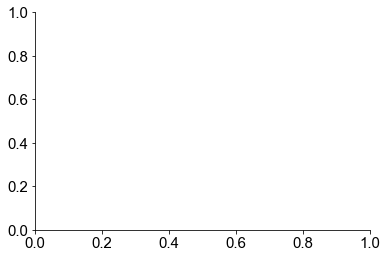

In [38]:
kas = [1]
kss = [0.1, 1, 10]
pprods = [5, 10, 50, 100, 500, 1000, 5000]
pdegs = [0.5, 1, 5, 10, 50, 100, 500]

pdegs.reverse()
pprods.reverse()

dfgs = []
dfps = []

fig, ax = plt.subplots()
tstart = time.time()

for ka in kas:
    for ks in kss:
        for pprod in pprods:
            for pdeg in pdegs:
                print("ka="+str(ka)+", ks="+str(ks)+", pp="+str(pprod)+", pd="+str(pdeg))
                df, df2 = plot_many_curves(ax, pprod, pdeg, ka, ks, False, 16)
                ax.clear()
                dfgs.append(df)
                dfps.append(df2)
                ctime = time.time()
                print(str(int(ctime-tstart))+" seconds taken")
                tstart = ctime

full_g_df = pd.concat(dfgs, ignore_index=True)
full_p_df = pd.concat(dfps, ignore_index=True)
full_g_df.to_csv('./gillespie_data.csv')
full_p_df.to_csv('./gillespie_protein_data.csv')

print(full_g_df.head())
print(full_p_df.head())

print("Done!")